In [2]:
!pip install numpy-stl trimesh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.3/709.3 kB 13.8 MB/s eta 0:00:00


STL file path: cat.stl
Number of slices: 100
0.998468055661775
Generated 97 valid slices with angles


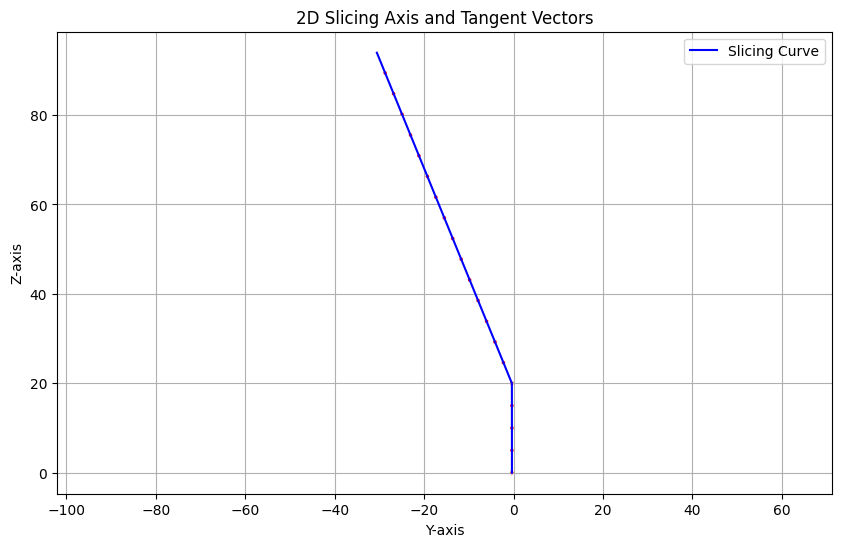

In [3]:
import numpy as np
import trimesh
from stl import mesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

blend_percent = 0.5  # Portion of model height over which blending occurs
lb = 54.1
la = 45.39

filament_diameter=1.75
layer_height = 0.2
extrusion_multiplier = 1/45

def read_stl(file_path):
    """Load STL and center it; set bottom flat at z=0."""
    mesh_data = mesh.Mesh.from_file(file_path)
    vertices = mesh_data.vectors.reshape(-1, 3)

    centroid = np.mean(vertices, axis=0)
    centroid[2] = 0  # Leave Z as-is for now
    centered = vertices - centroid

    min_z = np.min(centered[:, 2])
    centered[:, 2] -= min_z  # Align bottom to Z=0

    return trimesh.Trimesh(vertices=centered,
                         faces=np.arange(len(centered)).reshape(-1, 3))

def compute_2d_principal_axis(mesh):
    """Find the main direction (principal axis) in the YZ plane."""
    vertices = mesh.vertices
    yz_vertices = vertices[:, 1:]  # Drop X to focus on Y-Z only

    centroid = np.mean(yz_vertices, axis=0)
    cov = np.cov(yz_vertices - centroid, rowvar=False)
    vals, vecs = np.linalg.eigh(cov)
    principal = vecs[:, np.argmax(vals)]  # Largest variance = principal dir

    projs = np.dot(yz_vertices - centroid, principal)
    return centroid, principal, np.min(projs), np.max(projs)

def generate_2d_curve(mesh, transition_height=0.2):
    """Create a smooth curve in Y-Z space for slicing."""
    centroid, principal, pmin, pmax = compute_2d_principal_axis(mesh)
    bounds = mesh.bounds
    max_z = bounds[1, 2]

    principal /= np.linalg.norm(principal)  # Normalize direction

    transition_z = max_z * transition_height
    blend_range = max_z * blend_percent

    num_samples = 1000
    z_values = np.linspace(0, max_z, num_samples)
    curve_points = []
    tangents = []

    for z in z_values:
        if z < transition_z:
            pt = np.array([0, centroid[0], z])  # Just go up vertically
            tan = np.array([0, 0, 1])
        else:
            blend = min(1, (z - transition_z) / blend_range)
            dir_vec = (1 - blend)*np.array([0, 0, 1]) + blend*np.array([0, principal[0], principal[1]])
            dir_vec /= np.linalg.norm(dir_vec)

            progress = (z - transition_z) / (max_z - transition_z)
            y_offset = principal[0] * progress * (max_z - transition_z)
            z_offset = principal[1] * progress * (max_z - transition_z)
            pt = np.array([0, centroid[0] + y_offset, transition_z + z_offset])
            tan = dir_vec

        curve_points.append(pt)
        tangents.append(tan)

    return np.array(curve_points), np.array(tangents), z_values

def calculate_angle(tangent):
    """Get tilt angles relative to Z and X axes."""
    z_axis = np.array([0, 0, 1])
    x_axis = np.array([1, 0, 0])
    dot_product_z = np.dot(tangent, z_axis)
    dot_product_x = np.dot(tangent, x_axis)
    b_angle_rad = np.arccos(dot_product_z)
    c_angle_rad = np.arccos(dot_product_x)
    b_angle_deg = np.degrees(b_angle_rad)
    c_angle_deg = np.degrees(c_angle_rad)

    return b_angle_deg, c_angle_deg

def slice_with_2d_curve(mesh, num_slices):
    """Slice the mesh along a curved path and get tilt angles for each layer."""
    curve_points, tangents, z_samples = generate_2d_curve(mesh)

    diffs = np.diff(curve_points, axis=0)
    lengths = np.linalg.norm(diffs, axis=1)
    total_length = np.sum(lengths)
    layer_height = total_length / num_slices
    print(layer_height)

    slice_positions = np.linspace(0, total_length, num_slices)
    slice_indices = np.searchsorted(np.cumsum(lengths), slice_positions)

    slices = []
    b_angles = []
    c_angles = []
    for idx in slice_indices:
        origin = curve_points[idx]
        normal = tangents[idx]

        b_angle, c_angle = calculate_angle(normal)

        slice = mesh.section(plane_origin=origin, plane_normal=normal)
        if slice and len(slice.entities) > 0:
            slices.append(slice)
            b_angles.append(-1 * b_angle)
            c_angles.append(-1 * c_angle)

    return slices, b_angles, c_angles, curve_points, tangents

def inverse_kinematics(points, b_angle, c_angle):
    """Transform coordinates based on B and C tilt angles."""
    new_points = []

    for pt in points[0:]:
        X_0, Y_0, Z_0 = pt
        B = np.radians(b_angle)
        A = np.radians(c_angle)

        X_new_0 = X_0 + np.sin(A) * la + np.cos(A) * np.sin(B) * lb
        Y_new_0 = Y_0 - la + np.cos(A) * la - np.sin(A) * np.sin(B) * lb
        Z_new_0 = Z_0 + np.cos(B) * lb - lb

        new_points.append([X_new_0, Y_new_0, Z_new_0])

    return new_points

def generate_gcode(slices, b_angles, c_angles):
    """Create G-code with proper orientation and extrusion."""
    gcode = [
        "G0 F2000", "G1 F1000"
    ]

    filament_area = np.pi * (filament_diameter / 2) ** 2
    total_extrusion = 0

    for i, (layer, b_angle, c_angle) in enumerate(zip(slices, b_angles, c_angles)):
        gcode.append(f"\n; Layer {i+1}")

        for path in layer.entities:
            points = layer.vertices[path.points]
            new_points = inverse_kinematics(points, b_angle, c_angle)

            if len(new_points) == 0:
                continue
            gcode.append(f"G1 E{-2}")
            gcode.append(f"G0 X{new_points[0][0]:.2f} Y{new_points[0][1]:.2f} Z{new_points[0][2]:.2f} B{(b_angle-0.5 * c_angle):.2f} C{c_angle:.2f}")

            for j in range(1, len(new_points)):
                dx = new_points[j][0] - new_points[j-1][0]
                dy = new_points[j][1] - new_points[j-1][1]
                dz = new_points[j][2] - new_points[j-1][2]
                distance = np.sqrt(dx**2 + dy**2 + dz**2)

                extrusion_amount = distance * extrusion_multiplier

                if extrusion_amount >= 0.001:
                    if j == 1:
                        gcode.append(f"G1 X{new_points[j][0]:.2f} Y{new_points[j][1]:.2f} Z{new_points[j][2]:.2f} B{(b_angle-0.5 * c_angle):.2f} C{c_angle:.2f} E{extrusion_amount+2:.5f}")
                    else:
                        gcode.append(f"G1 X{new_points[j][0]:.2f} Y{new_points[j][1]:.2f} Z{new_points[j][2]:.2f} B{(b_angle-0.5 * c_angle):.2f} C{c_angle:.2f} E{extrusion_amount:.5f}")
                else:
                    gcode.append(f"G1 X{new_points[j][0]:.2f} Y{new_points[j][1]:.2f} Z{new_points[j][2]:.2f} B{(b_angle-0.5 * c_angle):.2f} C{c_angle:.2f} E0")

    return "\n".join(gcode)

def plot_slicing_axis(curve_points, tangents):
    """Quick plot to visualize the slicing curve and how the tool head tilts."""
    plt.figure(figsize=(10, 6))

    y = curve_points[:, 1]
    z = curve_points[:, 2]
    plt.plot(y, z, label="Slicing Curve", color="blue")

    for i in range(0, len(curve_points), 50):
        plt.quiver(y[i], z[i], tangents[i, 1], tangents[i, 2],
                   angles='xy', scale_units='xy', scale=5, color="red", width=0.005)

    plt.xlabel("Y-axis")
    plt.ylabel("Z-axis")
    plt.title("2D Slicing Axis and Tangent Vectors")
    plt.grid(True)
    plt.legend()
    plt.axis("equal")
    plt.show()

def main():
    stl_file = input("STL file path: ")
    num_slices = int(input("Number of slices: "))

    mesh = read_stl(stl_file)
    slices, b_angles, c_angles, curve_points, tangents = slice_with_2d_curve(mesh, num_slices)

    gcode = generate_gcode(slices, b_angles, c_angles)
    with open(stl_file.replace(".stl", ".gcode"), "w") as f:
        f.write(gcode)
    print(f"Generated {len(slices)} valid slices with angles")

    plot_slicing_axis(curve_points, tangents)

if __name__ == "__main__":
    main()
